### **Generate validation patches from validation scenes.**
#### We assume the first **10** scenes are used for validation.


In [1]:
import torch
import random
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from dataloader.preprocess import crop_scales, crop
from dataloader.preprocess import read_normalize
from utils.imgShow import imgShow, imsShow


/home/xin/miniconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_dset_scene = 'data/s2-dset/s2-scene'
dir_dset_truth = 'data/s2-dset/s2-truth'
dir_val_patch = 'data/s2-dset/s2-val-patch'
dir_val_patch_scales = 'data/s2-dset/s2-val-patch-scales'
patch_size_single = [256]
patch_size_scales = [512, 384, 256]
max_scene, min_scene = 10000, 0


In [3]:
paths_scene = sorted(glob(dir_dset_scene + '/*.tif'))
paths_truth = sorted(glob(dir_dset_truth + '/*.tif'))

## ---------- Validation data paths ----------- #
paths_val_scene, paths_val_truth = [], []
for val_id in range(10):
  path_scene_val = paths_scene[val_id]
  path_truth_val = paths_truth[val_id]
  paths_val_scene.append(path_scene_val)
  paths_val_truth.append(path_truth_val)

print(paths_val_scene[0])
print(paths_val_truth[0])
print('Number of val scenes:', len(paths_val_scene))


data/s2-dset/s2-scene/S2A_L2A_20190125_N0211_R034_6Bands_S1.tif
data/s2-dset/s2-truth/S2A_L2A_20190125_N0211_R034_S1_Truth.tif
Number of val scenes: 10


In [4]:
### ----- data read & pre-processing ------- ###
val_scenes, val_truths = read_normalize(paths_img=paths_val_scene, \
                paths_truth=paths_val_truth, max_bands=max_scene, min_bands=min_scene)
ziped_val_data = list(zip(val_scenes, val_truths))
len(ziped_val_data)


10

### **1. Single scale patch generation**
#### 

In [5]:
'''---- generate validation data (patch_group, truth)----'''
num_patch = 0
random.seed(999)
for i in range(20):
    # print(i)
    for scene, truth in ziped_val_data:
        patch, ptruth = crop(patch_size=patch_size_single)(image=scene, truth=truth)   ### single scale
        patch = torch.from_numpy(patch).to(dtype=torch.float32)
        ptruth = torch.from_numpy(ptruth).long()
        ptruth = torch.unsqueeze(ptruth, 0)
        path_val_patch = dir_val_patch + '/patch_'+ str(num_patch).rjust(3,'0')+'.pt'
        num_patch += 1
        # print(path_save)
        torch.save((patch, ptruth), path_val_patch)


### Check

In [6]:
## load data
paths_patch_val = sorted(glob(dir_val_patch+'/*'))
patches_val = [torch.load(path) for path in paths_patch_val]
print(len(patches_val))


200


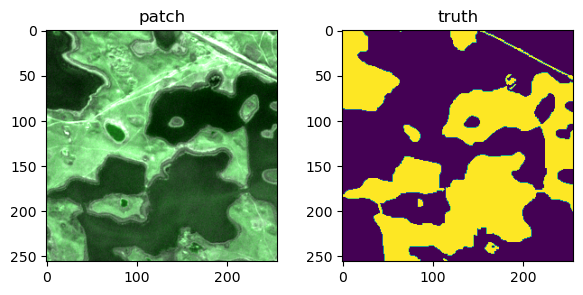

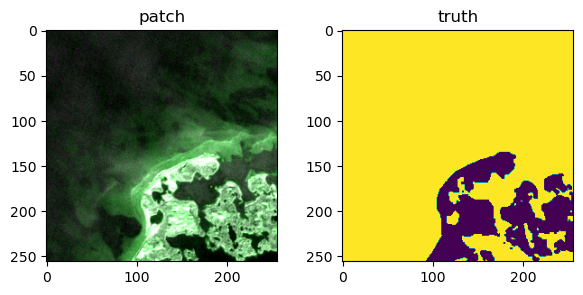

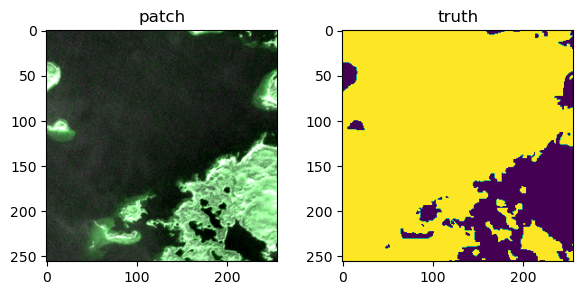

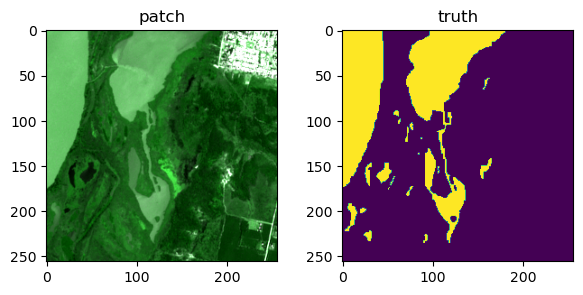

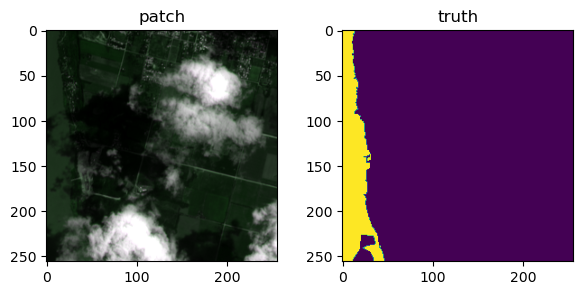

In [7]:
for idx in range(100,105):
  patch, truth = patches_val[idx]  ## (patches, truth)
  patch_ = patch.numpy().transpose(1,2,0)
  truth = truth.numpy().transpose(1,2,0)
  figs_list = [patch_, truth]
  figs_name = ['patch', 'truth']
  clip_list = [2, 0]
  col_bands_list = [(0,1,0), (0,0,0)]
  plt.figure(figsize=(7,3))
  imsShow(img_list=figs_list, img_name_list=figs_name, \
                        clip_list=clip_list, color_bands_list=col_bands_list)


### **2. Multiscale patches generation**

In [10]:
'''---- generate validation data (patch_group, truth)----'''
num_patch = 0
random.seed(999)
for i in range(20):
    # print(i)
    for scene, truth in ziped_val_data:
        patch_scales, ptruth = crop_scales(patch_size=patch_size_scales)(image=scene, truth=truth)
        patch_scales = [torch.from_numpy(patch).to(dtype=torch.float32) for patch in patch_scales] # 
        ptruth = torch.from_numpy(ptruth).long()
        ptruth = torch.unsqueeze(ptruth, 0)
        path_val_patch_scales = dir_val_patch_scales + '/patch_'+ str(num_patch).rjust(3,'0')+'.pt'
        num_patch += 1
        # print(path_save)
        torch.save((patch_scales, ptruth), path_val_patch_scales)


### Check

In [11]:
### load data
paths_patch_val_scales = sorted(glob(dir_val_patch_scales+'/*'))
patches_val = [torch.load(path) for path in paths_patch_val_scales]
print(len(patches_val))


200


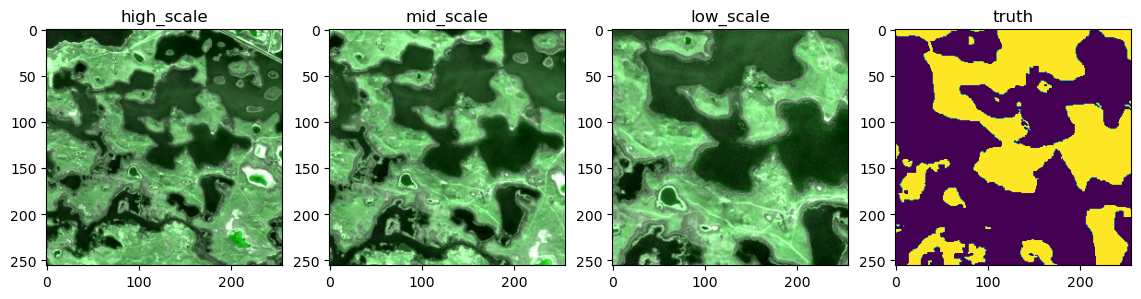

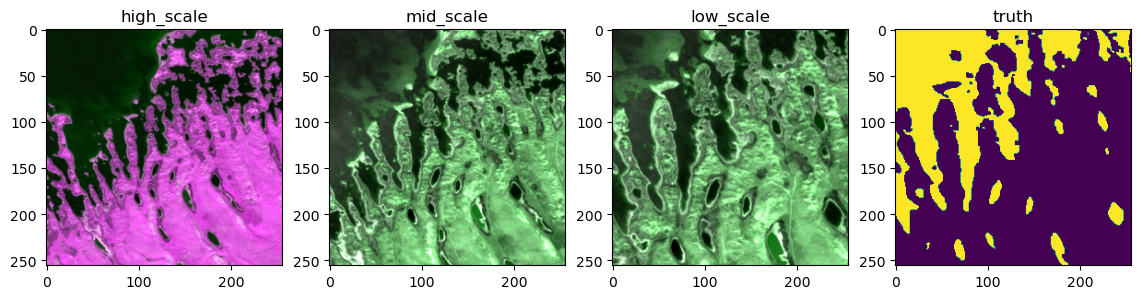

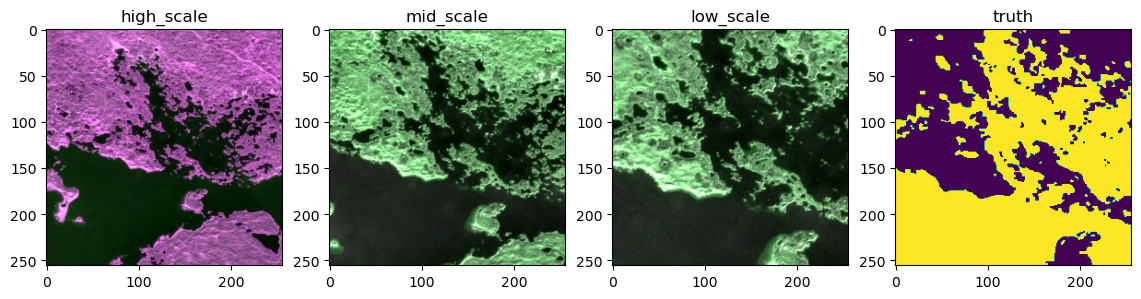

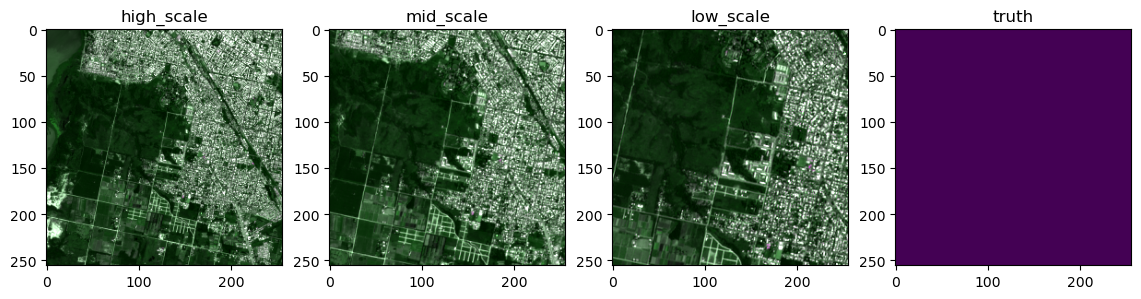

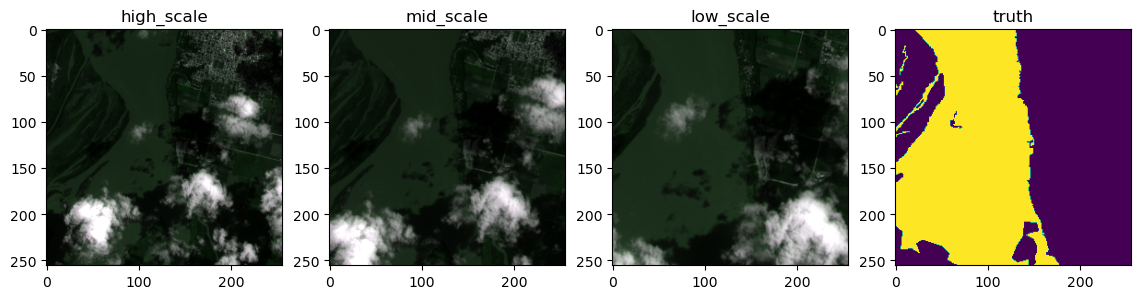

In [12]:
for idx in range(100,105):
  patches, truth = patches_val[idx]  ## (patches, truth)
  patches_ = [patch.numpy().transpose(1,2,0) for patch in patches]
  truth = truth.numpy().transpose(1,2,0)
  patches_list = [patches_[0],patches_[1],patches_[2],truth]
  patches_name = ['high_scale','mid_scale','low_scale','truth']
  clip_list = [1,1,1,0]
  col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0)]
  plt.figure(figsize=(14,5))
  imsShow(img_list=patches_list, img_name_list=patches_name, \
                                  clip_list=clip_list, color_bands_list=col_bands_list)
